In [1]:
from deep_q_network import DQNAgent
from double_deep_q_network import DoubleDQNAgent

from base_rl_agent_torch import ReplayMemory
from base_neural_model import EstimatorModelBase
from advantage_neural_model import AdvantageModel
import utils
import random
import copy
from Data_binary import *

In [2]:
# Fix seeds for reproducibility.
#utils.fix_seeds(2)

In [3]:
env = Data(unknown_rate=1)
env.loadfile("heartfail.csv")
env.normalize()
env.alpha = 0
env.cluster_K_means(7)
# this makes it so when we do the ranking, we only check against this number
# of data points
#env.set_validation(2000)
# makes the costs uniform; we won't have groups either
env.set_costs()
# max_cost is the fixed maximum cost the agent can take
env.max_cost = 6/12
# partition into training/test sets
test_env = env.split(0.80)
print("training points:", len(env.data))
print("test points:", len(test_env.data))

training points: 240
test points: 59


In [4]:
MAX_EPISODES = 4000
MAX_STEPS = 32
BATCH_SIZE = 32
buffer = ReplayMemory(100)

# Initiate the agent
model = AdvantageModel
agent = DoubleDQNAgent(env, 
                       model, 
                       buffer,max_steps=MAX_STEPS, 
                       max_episodes=MAX_EPISODES,
                       gamma=0.8,
                       epsilon_decay=0.9995,
                       exploration_penalty=-0.0,
                       verbose=0 # Verbosity level
                      )

In [5]:
#Train
episode_rewards = agent.train(env, MAX_EPISODES, MAX_STEPS, BATCH_SIZE)

We want to plot the reward per episode to examine agent performance.

In [6]:
def plot_reward_per_episode(episode_rewards):
    import matplotlib.pyplot as plt
    episode_rewards = episode_rewards[3500:5000]
    x = [i for i in range(len(episode_rewards))]
    plt.plot(x, episode_rewards)
    
plot_reward_per_episode(episode_rewards)

[1.73836186]
[4.52070775]


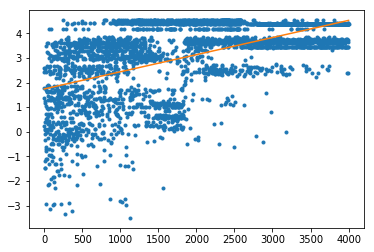

In [7]:
def plot_reward_per_episode(episode_rewards):
    import matplotlib.pyplot as plt
    episode_rewards = episode_rewards[0:15000]
    x = [i for i in range(len(episode_rewards))]
    plt.plot(x, episode_rewards,'.')
    x = np.array(x).reshape(-1,1)
    episode_rewards = np.array(episode_rewards).reshape(-1,1)
    from sklearn import datasets, linear_model
    regr = linear_model.LinearRegression()
    regr.fit(x,episode_rewards)
    y_pred = regr.predict(x)
    plt.plot(x,y_pred,'-')
    print(y_pred[0])
    print(y_pred[-1])
    
plot_reward_per_episode(episode_rewards)

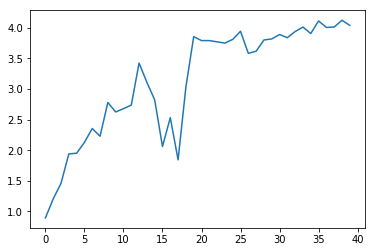

In [8]:
def plot_reward_per_episode(episode_rewards):
    import matplotlib.pyplot as plt
    episode_rewards = episode_rewards[0:]
    x = [i for i in range(len(episode_rewards)//100)]
    avg = [ sum(episode_rewards[i*100:(i+1)*100])/100 for i in range(len(episode_rewards)//100)]
    plt.plot(x, avg)

plot_reward_per_episode(episode_rewards)

In [9]:
#temp = test_env
#test_env = env
test_env.set_validation(10)
for iterations in range(1):
    # Now we evaluate the trained model by taking greedy actions
    total1 = 0
    total2 = 0
    tc1 = 0
    tc2 = 0

    N=len(test_env.data)
    test_env.it = 0
    for it in range(N):
        print("it:",test_env.it)
        observation = test_env.next_element() # Current observed state
        ob_cp = (copy.copy(observation[0]),copy.copy(observation[1]), copy.copy(observation[2]))
        #print("ob #:",observation[0])
        total_reward = 0
        agent.epsilon = 0
        i= 0
        done = False
        steps = 0
        cost = 0
        prev = []

        while True:
            if done:
                break;
            action = agent.get_action(observation,env)
            observation, reward, done, info = test_env.step(observation, action)
            total_reward += reward
            steps += 1
        #if (observation[1][-1] > test_env.max_cost):
        #    print("exceeded cost:", observation[1][-1])
        #else:
        #    print("cost1:", observation[1][-1])
        #if (prev != bool_feature(observation[1][:32])):
        #    print("different end state")
        prev = bool_feature(observation[1][:32])
        total1 += (test_env.score(observation))
        tc1 += observation[1][-1]

        observation = ob_cp
        done = False
        
        s2 = 0
        cost = 0
        while True:
            if done:
                break;
            actions = test_env.actions(observation)
            r = -1
            if (len(actions) != 1):
                r = random.randint(0,len(actions)-2)
            action = actions[r]
            #print("actions:",actions)
            if action != -1 and action < len(observation[1])-1:
                cost += env.costs[action]
            observation, reward, done, info = test_env.step(observation, action)
        total2+=(test_env.score(observation))
        #print()
        tc2 += observation[1][-1]

    


it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 10
it: 11
it: 12
it: 13
it: 14
it: 15
it: 16
it: 17
it: 18
it: 19
it: 20
it: 21
it: 22
it: 23
it: 24
it: 25
it: 26
it: 27
it: 28
it: 29
it: 30
it: 31
it: 32
it: 33
it: 34
it: 35
it: 36
it: 37
it: 38
it: 39
it: 40
it: 41
it: 42
it: 43
it: 44
it: 45
it: 46
it: 47
it: 48
it: 49
it: 50
it: 51
it: 52
it: 53
it: 54
it: 55
it: 56
it: 57
it: 58


In [10]:
print("total final score RL:", total1)
print("total final score rand:", total2)
print("total final cost RL:", tc1/N)
print("total final cost rand:", tc2/N)
# Saving the network
#agent.to_pickle("somefile.pickle")

total final score RL: 2.3839600051432193
total final score rand: 36.45266228804618
total final cost RL: 0.49999999999999994
total final cost rand: 0.49999999999999994


##### 